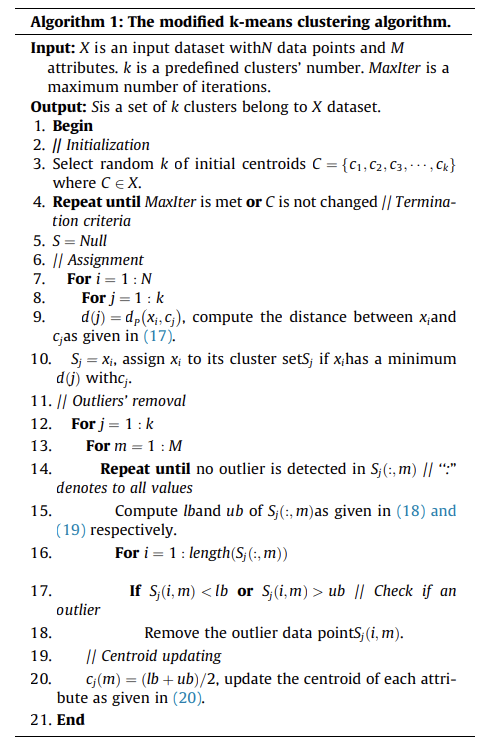

https://pythonprogramming.net/k-means-from-scratch-machine-learning-tutorial/

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io
import time
from numpy import matlib as mb
import random
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [3]:
def calc_distance(A, B):
    if(A.max() > B.max()):
        Y = A.max()
    else:
        Y = B.max()
    if(A.min() > B.min()):
        Z = A.min()
    else:
        Z = B.min()

    #             Y = np.maximum(X, cluster_mean)
    #             Z = np.minimum(X, cluster_mean)
    r_max = 90
    r_min = 1
    A = (A-Z)/(Y-Z) * (r_max-r_min) + r_min
    B = (B-Z)/(Y-Z) * (r_max-r_min) + r_min

    alpha = []
    beta = []
#     print(f'A={A} B={B}')
    for a, b in zip(A, B):
#         print(np.arctan(a/b))
#         print(np.arctan(b/a))
        alpha.append(np.degrees(np.arctan(a/b)))
        beta.append(np.degrees(np.arctan(b/a)))
    alpha, beta = np.array(alpha), np.array(beta)
    distance = np.linalg.norm(alpha - beta)/np.sqrt(len(A))
    return distance

In [4]:
def tukeys_method(df):
#Takes two parameters: dataframe & variable of interest as string
    outlier_index = []
    lb_, ub_ = [], []
    for variable in df:
        q1 = df[variable].quantile(0.25)
        q3 = df[variable].quantile(0.75)
        iqr = q3-q1
        r1 = 0.85
        r2 = 0.65

        mean = df[variable].mean()
        GM = (df[variable]>mean).sum()
        LM = (df[variable]<mean).sum()
#         print(GM, LM)

        if(GM < LM):
            lb = q1 - r1*iqr
            ub = q3 + r2*iqr
        elif(GM > LM):
            lb = q1 - r2*iqr
            ub = q3 + r1*iqr
        else:
            lb = q1 - (r1+r2)/2 * iqr
            ub = q3 + (r1+r2)/2 * iqr

        lb_.append(lb)
        ub_.append(ub)

        for index, x in enumerate(df[variable]):
            if x <= lb or x >= ub:
                outlier_index.append(index)
    return list(set(outlier_index)), lb_, ub_

In [5]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=50):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
#             print(data.shape[0])
            index = random.randint(0,data.shape[0]-1)
#             print(index)
            self.centroids[i] = data[index]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []
            self.df = pd.DataFrame(data)
                    
#             index, lb, ub = tukeys_method(df)
#             display(index)
#             df = df.drop(index)
#             display(df)
            
            self.data = self.df.to_numpy()
            for featureset in data:
                distances = [calc_distance(featureset, self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)
            
            df_empty = pd.DataFrame()
            for classification in self.classifications:
                df = pd.DataFrame(self.classifications[classification])
#                 print(df.shape)
                index, lb, ub = tukeys_method(df)
#                 df = df.drop(index)
                df_empty = df_empty.append(df)
                self.centroids[classification] = np.add(lb, ub)/2
#                 self.centroids[classification] = np.average(self.classifications[classification],axis=0)
                if(type(np.isnan(np.average(self.classifications[classification],axis=0))) != np.ndarray):
                    return False
#                     self.centroids[classification] = prev_centroids[classification]
#                     if np.isnan(np.average(self.classifications[classification],axis=0)):
#                         print(self.classifications[classification])

            optimized = True
            
#             df = pd.DataFrame(data)
                    
#             index, lb, ub = tukeys_method(df)
# #             display(index)
#             df = df.drop(index)
# #             display(df)
            
            data = df_empty.to_numpy()
#             display(df_empty)
        
#             print(self.centroids)

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
#                     print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                return True
        return True

    def predict(self,data):
        distances = [calc_distance(data,self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [6]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    y_true, y_pred = y_true.to_list(), y_pred.to_list()
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# Metrics

In [7]:
results = {}

# Vertebrae Dataset

From https://www.kaggle.com/caesarlupum/vertebralcolumndataset

In [8]:
dataset_name = "Vertebrae"

In [9]:
import numpy as np
import pandas as pd

df = pd.read_csv('dataset/vertebrae.csv')
df = df.rename(columns={"class": "target"})
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [10]:
cluster_array = np.array(df.drop('target',axis=1))

In [11]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Vertebrae Dataset: 0.6903225806451613
Mean accuracy for Vertebrae Dataset: 0.6777096774193546
STD accuracy for Vertebrae Dataset: 0.001519556866234056


In [12]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Wine Dataset

From sklearn.dataset

In [13]:
dataset_name = "Wine"

In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

wine = load_wine()

df = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

In [15]:
cluster_array = np.array(df.drop('target',axis=1))

In [16]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Wine Dataset: 0.949438202247191
Mean accuracy for Wine Dataset: 0.8470983435653887
STD accuracy for Wine Dataset: 0.06849414877634187


In [17]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Iris Dataset

From sklearn.dataset

In [18]:
dataset_name = "Iris"

In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [20]:
cluster_array = np.array(df.drop('target',axis=1))

In [21]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Iris Dataset: 0.96
Mean accuracy for Iris Dataset: 0.8875694444444444
STD accuracy for Iris Dataset: 0.11005730742758466


In [22]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Glass Dataset

From https://www.kaggle.com/uciml/glass

In [23]:
dataset_name = "Glass"

In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

df = pd.read_csv('dataset/glass.csv')
df = df.rename(columns={"Type": "target"})
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [25]:
cluster_array = np.array(df.drop('target',axis=1))

In [26]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Glass Dataset: 0.6495327102803738
Mean accuracy for Glass Dataset: 0.5701459624068046
STD accuracy for Glass Dataset: 0.03462676292982067


In [27]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Cancer Dataset

From https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [28]:
dataset_name = "Cancer"

In [29]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

df = pd.read_csv('dataset/cancer.csv', index_col=0)
df = df.drop(['Unnamed: 32'], axis=1)
df = df.rename(columns={"diagnosis": "target"})
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [30]:
cluster_array = np.array(df.drop('target',axis=1))

In [31]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Cancer Dataset: 0.9156414762741653
Mean accuracy for Cancer Dataset: 0.9099962720349364
STD accuracy for Cancer Dataset: 0.013282168518229687


In [32]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Ecoli Dataset

From https://www.kaggle.com/elikplim/ecoli-data-set

In [33]:
# dataset_name = "Ecoli"

In [34]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import load_wine

# df = pd.read_csv('dataset/ecoli.csv', index_col=0, delim_whitespace=True)
# display(df)
# df = df.rename(columns={"cp": "target"})
# le = preprocessing.LabelEncoder()
# df['target'] = le.fit_transform(df['target'])

In [35]:
# cluster_array = np.array(df.drop('target',axis=1))

In [36]:
# acc = []
# for i in range(100):
#     clf = K_Means(k=df.target.nunique())
#     cluster_array = np.array(df.drop('target',axis=1))
#     success = clf.fit(cluster_array)
#     if(success):
#         result = np.array([])

#         for element in cluster_array:
#             result = np.append(result, clf.predict(element))

#         df1 = pd.DataFrame(data= np.c_[df, result],
#                              columns= df.columns.to_list() + ['prediction'])


#         acc.append(purity_score(df1['target'], df1['prediction']))
# print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
# print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
# print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

In [37]:
# results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Seed Dataset

From https://www.kaggle.com/dongeorge/seed-from-uci

In [38]:
dataset_name = "Seed"

In [39]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

df = pd.read_csv('dataset/seed.csv')
display(df)
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

A      P       C     LK     WK  A_Coef    LKG  target
0    15.26  14.84  0.8710  5.763  3.312   2.221  5.220       0
1    14.88  14.57  0.8811  5.554  3.333   1.018  4.956       0
2    14.29  14.09  0.9050  5.291  3.337   2.699  4.825       0
3    13.84  13.94  0.8955  5.324  3.379   2.259  4.805       0
4    16.14  14.99  0.9034  5.658  3.562   1.355  5.175       0
..     ...    ...     ...    ...    ...     ...    ...     ...
205  12.19  13.20  0.8783  5.137  2.981   3.631  4.870       2
206  11.23  12.88  0.8511  5.140  2.795   4.325  5.003       2
207  13.20  13.66  0.8883  5.236  3.232   8.315  5.056       2
208  11.84  13.21  0.8521  5.175  2.836   3.598  5.044       2
209  12.30  13.34  0.8684  5.243  2.974   5.637  5.063       2

[210 rows x 8 columns]

In [40]:
cluster_array = np.array(df.drop('target',axis=1))

In [41]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Seed Dataset: 0.8047619047619048
Mean accuracy for Seed Dataset: 0.7540816326530613
STD accuracy for Seed Dataset: 0.07038844247134311


In [42]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

# Blood Transfusion Dataset

From https://www.kaggle.com/ninalabiba/blood-transfusion-dataset

In [43]:
dataset_name = "Blood"

In [44]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

df = pd.read_csv('dataset/blood.csv')
df = df.rename(columns={"whether he/she donated blood in March 2007": "target"})
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [45]:
cluster_array = np.array(df.drop('target',axis=1))

In [46]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Blood Dataset: 0.7620320855614974
Mean accuracy for Blood Dataset: 0.7620320855614973
STD accuracy for Blood Dataset: 1.1102230246251565e-16


In [47]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

In [48]:
results.keys()

dict_keys(['Vertebrae', 'Wine', 'Iris', 'Glass', 'Cancer', 'Seed', 'Blood'])

# Balance Scale Dataset

From https://www.kaggle.com/mysticvalley/balance-scale

In [49]:
dataset_name = "Balance"

In [50]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

df = pd.read_csv('dataset/balance.csv')
df = df.rename(columns={"Class": "target"})
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [51]:
cluster_array = np.array(df.drop('target',axis=1))

In [52]:
acc = []
for i in range(100):
    clf = K_Means(k=df.target.nunique())
    cluster_array = np.array(df.drop('target',axis=1))
    success = clf.fit(cluster_array)
    if(success):
        result = np.array([])

        for element in cluster_array:
            result = np.append(result, clf.predict(element))

        df1 = pd.DataFrame(data= np.c_[df, result],
                             columns= df.columns.to_list() + ['prediction'])


        acc.append(purity_score(df1['target'], df1['prediction']))
print(f'Best accuracy for {dataset_name} Dataset: {np.max(acc)}')
print(f'Mean accuracy for {dataset_name} Dataset: {np.mean(acc)}')
print(f'STD accuracy for {dataset_name} Dataset: {np.std(acc)}')

Best accuracy for Balance Dataset: 0.664
Mean accuracy for Balance Dataset: 0.4869770491803278
STD accuracy for Balance Dataset: 0.0298926187141198


In [53]:
results[dataset_name] = {"best": np.max(acc), "mean": np.mean(acc), "std": np.std(acc)}

In [54]:
best = []
mean = []

for k in results:
    print(f'For dataset {k}')
    print(f'Best Accuracy: {results[k]["best"]}, Mean Accuracy: {results[k]["mean"]}, STD Accuracy: {results[k]["std"]}\n')

For dataset Vertebrae
Best Accuracy: 0.6903225806451613, Mean Accuracy: 0.6777096774193546, STD Accuracy: 0.001519556866234056

For dataset Wine
Best Accuracy: 0.949438202247191, Mean Accuracy: 0.8470983435653887, STD Accuracy: 0.06849414877634187

For dataset Iris
Best Accuracy: 0.96, Mean Accuracy: 0.8875694444444444, STD Accuracy: 0.11005730742758466

For dataset Glass
Best Accuracy: 0.6495327102803738, Mean Accuracy: 0.5701459624068046, STD Accuracy: 0.03462676292982067

For dataset Cancer
Best Accuracy: 0.9156414762741653, Mean Accuracy: 0.9099962720349364, STD Accuracy: 0.013282168518229687

For dataset Seed
Best Accuracy: 0.8047619047619048, Mean Accuracy: 0.7540816326530613, STD Accuracy: 0.07038844247134311

For dataset Blood
Best Accuracy: 0.7620320855614974, Mean Accuracy: 0.7620320855614973, STD Accuracy: 1.1102230246251565e-16

For dataset Balance
Best Accuracy: 0.664, Mean Accuracy: 0.4869770491803278, STD Accuracy: 0.0298926187141198

